In [191]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 20

def isEven(n):
    return n % 2 == 0

def filter_string(s):
    return ''.join(filter(lambda x: x in string.printable, s))

def split_words(s):
    return re.sub("[^\w]", " ",  s).split()

In [197]:
leis_dir = 'leis_vetadas/'
leis = []
leis_split = []
words = []
for fname in os.listdir(leis_dir):
    with open(leis_dir+fname, "r", encoding="utf-8") as f:
        r = f.read()
        leis.append(r)
        leis_split.append(r.split('**VETO**'))
        file_words = text_to_word_sequence(r)
        # file_words = split_words(r)
        words += file_words


In [210]:
#X_tmp = []
#y_tmp = []
sentences = []

for l in leis_split:
    i = 0
    sx = []
    sy = []
    for s in l:
        i += 1
        w = text_to_word_sequence(s)
        sx += w
        if isEven(i):
            sy += ["veto" for _ in range(len(w))]
        else:
            sy += ["ok" for _ in range(len(w))]
    sentences.append([[sx[a],sy[a]] for a in range(len(w))])

# sentences = list(zip(X_tmp, y_tmp))

In [211]:
vocab = list(set(words))
n_words = len(vocab)

tags = ["ok","veto"]
n_tags = len(tags)

word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["paulo"]))
print("ok {}".format(tag2idx["ok"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 1274
ok 1
Raw Sample:  projeto de lei nº 283 de 2012 institui a semana de conscientização prevenção e combate a verminose no estado de são paulo e dá outras providências a assembleia legislativa do estado de são paulo decreta artigo 1º fica a secretaria estadual de saúde autorizada instituir a semana de conscientização prevenção e combate a verminose no estado de são paulo parágrafo único a semana de conscientização prevenção e combate a verminose no estado são paulo mencionada no caput deste artigo deverá obrigatoriamente abranger a primeira semana de abril artigo 2º os objetivos da semana de conscientização prevenção e combate a verminose no estado de são paulo i promover a conscientização e orientar com regras básicas de cuidados de higiene domiciliar e pessoal para evitar a contaminação através de profissionais qualificados ii criar a oportunidade de integração de órgãos e entidades públicos e privados em ações conjuntas em benefício da co

In [212]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from keras.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 75, 20)            91200     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_9 (CRF)                  (None, 75, 3)             168       
Total params: 124,818
Trainable params: 124,818
Non-trainable params: 0
_________________________________________________________________


In [217]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=200,
                    validation_split=0.3, verbose=2)

Train on 14 samples, validate on 6 samples
Epoch 1/200
 - 0s - loss: 0.0026 - crf_viterbi_accuracy: 0.9981 - val_loss: 2.0054 - val_crf_viterbi_accuracy: 1.0000
Epoch 2/200
 - 0s - loss: 0.0016 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0056 - val_crf_viterbi_accuracy: 1.0000
Epoch 3/200
 - 0s - loss: 0.0014 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0055 - val_crf_viterbi_accuracy: 1.0000
Epoch 4/200
 - 0s - loss: 0.0014 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0054 - val_crf_viterbi_accuracy: 1.0000
Epoch 5/200
 - 0s - loss: 0.0014 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0053 - val_crf_viterbi_accuracy: 1.0000
Epoch 6/200
 - 0s - loss: 0.0014 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0053 - val_crf_viterbi_accuracy: 1.0000
Epoch 7/200
 - 0s - loss: 0.0016 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0054 - val_crf_viterbi_accuracy: 1.0000
Epoch 8/200
 - 0s - loss: 0.0022 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0052 - val_crf_viterbi_accuracy: 1.0000
Epoch 9/200
 

Epoch 68/200
 - 0s - loss: 4.0853e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0047 - val_crf_viterbi_accuracy: 1.0000
Epoch 69/200
 - 0s - loss: 0.0011 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 70/200
 - 0s - loss: 0.0021 - crf_viterbi_accuracy: 0.9990 - val_loss: 2.0046 - val_crf_viterbi_accuracy: 1.0000
Epoch 71/200
 - 0s - loss: 1.2091e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0045 - val_crf_viterbi_accuracy: 1.0000
Epoch 72/200
 - 0s - loss: 1.4137e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0045 - val_crf_viterbi_accuracy: 1.0000
Epoch 73/200
 - 0s - loss: 1.2899e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0045 - val_crf_viterbi_accuracy: 1.0000
Epoch 74/200
 - 0s - loss: 1.2230e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0045 - val_crf_viterbi_accuracy: 1.0000
Epoch 75/200
 - 0s - loss: 1.1260e-04 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0045 - val_crf_viterbi_accuracy: 1.0000
Epoch 76/200
 - 0s - los

Epoch 135/200
 - 0s - loss: 3.1157e-05 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 136/200
 - 0s - loss: 2.0403e-05 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 137/200
 - 0s - loss: 3.0634e-05 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0043 - val_crf_viterbi_accuracy: 1.0000
Epoch 138/200
 - 0s - loss: 3.4296e-06 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 139/200
 - 0s - loss: 1.3079e-05 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 140/200
 - 0s - loss: 1.0754e-05 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0043 - val_crf_viterbi_accuracy: 1.0000
Epoch 141/200
 - 0s - loss: -4.6503e-07 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0043 - val_crf_viterbi_accuracy: 1.0000
Epoch 142/200
 - 0s - loss: 4.0690e-06 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.0044 - val_crf_viterbi_accuracy: 1.0000
Epoch 1

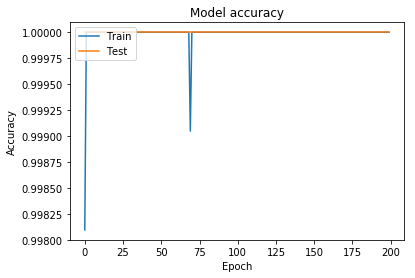

In [218]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [216]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00        54
          ok       0.59      1.00      0.74       101
        veto       0.00      0.00      0.00        70

   micro avg       0.69      0.69      0.69       225
   macro avg       0.53      0.67      0.58       225
weighted avg       0.51      0.69      0.57       225

